<a href="https://colab.research.google.com/github/Alok952/Bubble.github.io/blob/main/Leaf_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Libraries imported**

In [3]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [4]:
BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [5]:

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "/content/drive/MyDrive/PlantVillage",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


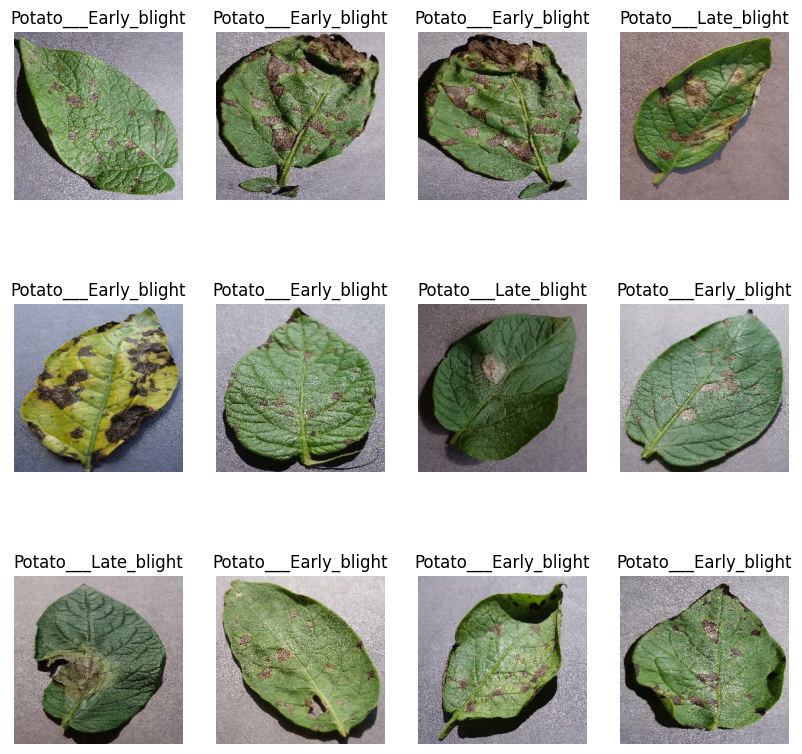

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(dataset)

68

In [10]:
train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54)
len(train_ds)

54

In [12]:
test_ds = dataset.skip(54)
len(test_ds)

14

In [13]:
val_size=0.1
len(dataset)*val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)
len(val_ds)


6

In [15]:
test_ds = test_ds.skip(6)
len(test_ds)

8

In [16]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [23]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [24]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [25]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

In [27]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [28]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=15,
)

Epoch 1/15
54/54 [==============================] - 415s 5s/step - loss: 0.9116 - accuracy: 0.5330 - val_loss: 0.8445 - val_accuracy: 0.5260
Epoch 2/15
54/54 [==============================] - 251s 5s/step - loss: 0.6236 - accuracy: 0.7257 - val_loss: 0.4768 - val_accuracy: 0.7865
Epoch 3/15
54/54 [==============================] - 252s 5s/step - loss: 0.2685 - accuracy: 0.8935 - val_loss: 0.1858 - val_accuracy: 0.9167
Epoch 4/15
54/54 [==============================] - 254s 5s/step - loss: 0.2980 - accuracy: 0.8808 - val_loss: 0.4101 - val_accuracy: 0.8542
Epoch 5/15
54/54 [==============================] - 251s 5s/step - loss: 0.1371 - accuracy: 0.9416 - val_loss: 0.3952 - val_accuracy: 0.8438
Epoch 6/15
54/54 [==============================] - 254s 5s/step - loss: 0.1227 - accuracy: 0.9514 - val_loss: 0.3190 - val_accuracy: 0.8854
Epoch 7/15
54/54 [==============================] - 247s 5s/step - loss: 0.1368 - accuracy: 0.9514 - val_loss: 1.1861 - val_accuracy: 0.6562
Epoch 8/15
54

In [31]:
score= model.evaluate(test_ds)

8/8 [==============================] - 9s 1s/step - loss: 0.1177 - accuracy: 0.9648


In [32]:
score

[0.11767344176769257, 0.96484375]

In [33]:
history

In [34]:
history.params


{'verbose': 1, 'epochs': 15, 'steps': 54}

In [35]:
history.history.keys()


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [36]:
type(history.history['loss'])



list

In [37]:
len(history.history['loss'])


15

In [38]:
history.history['loss'][:5] # show loss for first 5 epochs


[0.9116368889808655,
 0.6236213445663452,
 0.26847055554389954,
 0.2979896664619446,
 0.13714784383773804]

In [39]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 1s 1s/step
predicted label: Potato___Early_blight


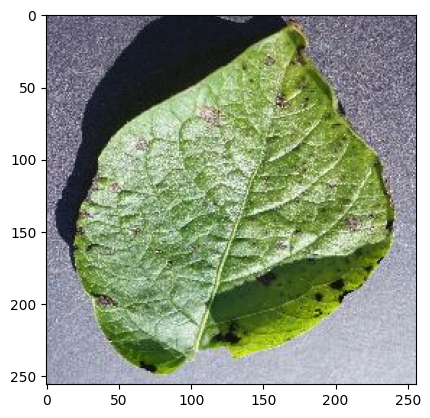

In [41]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [42]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

In [43]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")

1/1 [==============================] - 0s 55ms/step


In [10]:
import os
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# Ensure the 'models' directory exists
if not os.path.exists("models"):
    os.makedirs("models")

# Define the model
model = Sequential([
    Dense(64, activation='relu', input_shape=(32,)),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Dummy data for demonstration purposes
import numpy as np
x_train = np.random.random((1000, 32))
y_train = np.random.random((1000, 10))

# Train the model (for demonstration, we use dummy data and few epochs)
model.fit(x_train, y_train, epochs=5)

# Find the next model version number
model_version = max([int(i) for i in os.listdir("models") if i.isdigit()] + [0]) + 1

# Save the model
model.save(f"models/{model_version}")



Epoch 1/5
32/32 [==============================] - 1s 5ms/step - loss: 11.7368 - accuracy: 0.0950
Epoch 2/5
32/32 [==============================] - 0s 3ms/step - loss: 15.7107 - accuracy: 0.1170
Epoch 3/5
32/32 [==============================] - 0s 4ms/step - loss: 28.0649 - accuracy: 0.1140
Epoch 4/5
32/32 [==============================] - 0s 5ms/step - loss: 54.9446 - accuracy: 0.1090
Epoch 5/5
32/32 [==============================] - 0s 4ms/step - loss: 94.9831 - accuracy: 0.1110
